In [3]:
import os
import pandas as pd
import numpy as np
import sys
import csv
from time import strptime
import json
from datetime import datetime as dt
from datetime import date
from statistics import mean
import math
import pickle

In [4]:
csv.field_size_limit(sys.maxsize)
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_columns = None
pd.options.display.max_rows = 10000
pd.set_option('display.max_colwidth', -1)

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [66]:
df = pd.read_csv('10 df.csv')

In [67]:
num_actors = 10
def swap_cast(row):
    actors = []
    for i in range(1,num_actors+1):
        actors.append(row[f'cast_{i}_name'])
    not_empty_actors = [a for a in actors if not pd.isna(a)]
    padded_actors = not_empty_actors + [np.nan] * (num_actors-len(not_empty_actors))
    for i in range(num_actors):
        row[f'cast_{i+1}_name'] = padded_actors[i]
    return row

In [ ]:
df_shifted_actors = df.copy()
for i, row in df_shifted_actors.iterrows():
    if i in range(0, df.shape[0], 100):
        print(i)
    df_shifted_actors.iloc[i] = swap_cast(row)

In [69]:
for i in range(1, 11):
    print(len([a for a in df_shifted_actors[f'cast_{i}_name'] if pd.isna(a)]))

1
15
38
78
145
251
390
542
828
1614


In [797]:
df_shifted_actors.to_csv('10 1 df_shifted_actors.csv', mode='w+', index=False)

In [312]:
df_shifted_actors = pd.read_csv('10 1 df_shifted_actors.csv')

In [314]:
df_shifted_actors.shape

(7536, 201)

In [321]:
ids_to_delete = []
genre_cols = [c for c in df.columns if 'genre' in c]

def to_delete(movie): 
    return not sum([1 for col in genre_cols if movie[col]]) or pd.isna(movie.overview)

for i, movie in added_collection_info.iterrows():
    if to_delete(movie):
        ids_to_delete.append(movie.id)

indexes = df_shifted_actors.loc[df_shifted_actors.id.isin(ids_to_delete)].index
df_deleted = df_shifted_actors.drop(indexes, axis=0)

In [323]:
df_deleted.to_csv('10 2 df_deleted.csv', mode='w+', index=False)

In [324]:
df_deleted = pd.read_csv('10 2 df_deleted.csv')

In [325]:
df_8_actors = df_deleted.copy()
for i in range(9, 11):
    df_8_actors.drop([f'cast_{i}_name', f'cast_{i}_gender'], axis=1, inplace=True)

In [326]:
df_8_actors.shape

(7494, 197)

In [327]:
list(df_8_actors.columns)

['budget',
 'id',
 'original_language',
 'original_title',
 'overview',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'title',
 'year',
 'month',
 'day',
 'weekend',
 'collection_name',
 'cast_1_name',
 'cast_1_gender',
 'cast_2_name',
 'cast_2_gender',
 'cast_3_name',
 'cast_3_gender',
 'cast_4_name',
 'cast_4_gender',
 'cast_5_name',
 'cast_5_gender',
 'cast_6_name',
 'cast_6_gender',
 'cast_7_name',
 'cast_7_gender',
 'cast_8_name',
 'cast_8_gender',
 'crew__lighting__gaffer',
 'crew__sound__boom_operator',
 'crew__sound__dialogue_editor',
 'crew__sound__foley',
 'crew__sound__music',
 'crew__sound__music_editor',
 'crew__sound__music_supervisor',
 'crew__sound__original_music_composer',
 'crew__sound__sound_designer',
 'crew__sound__sound_effects_editor',
 'crew__sound__sound_mixer',
 'crew__sound__sound_re_recording_mixer',
 'crew__sound__supervising_sound_editor',
 'crew__directing__director__1',
 'crew__directing__first_assistant_director',
 'crew__directing__script_

In [328]:
actors = []
for i in range(1, 9):
    actors.extend(df_8_actors[f'cast_{i}_name'])
all_actors = list(set(actors))

In [329]:
len(all_actors)

23891

In [304]:
def get_real_columns(name_prefix, name_suffix, num_columns):
    return [f'{name_prefix}{j}{name_suffix}' for j in range(1, num_columns+1)]

def get_date_from_movie(movie):
    return date(movie['year'], movie['month'], movie['day'])

def get_info_df_movies_per_value_range_columns(df, columns):
    result = {}
    for i, row in df.iterrows():
        if i in range(0, df.shape[0], 100):
            print(i)
        for col in columns:
            value = row[col]
            if not pd.isna(value):
                if value in list(result.keys()):
                    result[value]['movies'] = result[value]['movies'].append(df.iloc[[i]])
                else:
                    result[value] = {'movies': df.iloc[[i]]}
    return result

def calculate_info_per_previous_movies_per_value(df, info_dict, calc_budget=False, calc_movies_before=False, 
                                                 calc_experience=False, calc_profitability=False, calc_revenue=False):
    smooth_parameter = 5
    mean_profitability = df['profitability'].mean()
    for value_name in info_dict:
        value = info_dict[value_name]
        value['avg_profit'] = {}
        if calc_budget:
            value['avg_budget'] = {}
        if calc_experience:
            value['experience'] = {}
        if calc_profitability:
            value['avg_profitability'] = {}
        if calc_revenue:
            value['avg_revenue'] = {}
        if calc_movies_before:
            value['movies_before'] = {}

        movies = value['movies']
        for movie_index, movie in movies.iterrows():
            current_date = get_date_from_movie(movie)
            str_date = str(current_date)
            if calc_experience and str_date not in list(value['experience'].keys()):
                value['experience'][str_date] = movie['year'] - movies.year.min()
            if str_date not in list(value['avg_profit'].keys()):
                movies_before = movies[movies.apply(lambda row: (date(row.year, row.month, row.day) < current_date), axis=1)]
                if not movies_before.empty:
                    value['avg_profit'][str_date] = get_average_profit(movies_before)
                    if calc_movies_before:
                        value['movies_before'][str_date] = movies_before.shape[0]
                    if calc_revenue:
                        value['avg_revenue'][str_date] = movies_before['revenue'].mean()                        
                    if calc_budget:
                        value['avg_budget'][str_date] = movies_before['budget'].mean()
                    if calc_profitability:
                        value['avg_profitability'][str_date] = smooth_mean_profitability(movies_before, mean_profitability, smooth_parameter)
                    
                    
def get_columns_from_info_dict(df, info_dict, real_columns, new_column_prefix='', nested_info=False):
    def get_first_key(d):
        return d[list(d.keys())[0]]
    
    new_columns_data = {}
    for index, real_column in enumerate(real_columns):
        print(real_column)
        root = info_dict[real_column] if nested_info else info_dict
        info_names = [key for key in get_first_key(root).keys() if key != 'movies']
        new_column_names = [f'{real_column}_{key}' if nested_info or len(real_columns) == 1 else f'{new_column_prefix}_{index+1}_{key}' for key in info_names] 
            
        for new_column_name in new_column_names:
            new_columns_data[new_column_name] = []

        for movie_index, movie in df.iterrows():
            value = movie[real_column]
            str_date = str(get_date_from_movie(movie))
            if pd.isna(value):
                for col in new_column_names:
                    new_columns_data[col].append(np.nan)
            else:
                for name_index, new_column_name in enumerate(new_column_names):
                    year_info = root[value][info_names[name_index]].get(str_date, np.nan)
                    new_columns_data[new_column_name].append(year_info)
    return new_columns_data

In [305]:
def smooth_mean(mean, counts, overall_mean, m):
    return (counts * mean + m * overall_mean)/(counts + m)

def smooth_field(df, field, overall_mean, m):
    counts = df.shape[0]
    mean = df[field].mean()
    return smooth_mean(mean, counts, overall_mean, m)

def smooth_mean_profitability(df, mean_profitability, m):
    return smooth_field(df, 'profitability', mean_profitability, m)

def get_average_profit(df):
    return (df['revenue'] - df['budget']).mean()

def get_actor_experience(df, year):
    return year - df.year.min()

In [335]:
real_columns = get_real_columns('cast_', '_name', 8)

In [ ]:
all_actors_info = get_info_df_movies_per_value_range_columns(df_8_actors, real_columns)

In [337]:
all_actors_info_copy = all_actors_info.copy()

In [338]:
calculate_info_per_previous_movies_per_value(df_8_actors, all_actors_info_copy, calc_movies_before=True, calc_budget=True, calc_experience=True, calc_profitability=True)

In [339]:
cast_columns = get_columns_from_info_dict(df_8_actors, all_actors_info_copy, real_columns, new_column_prefix='cast')

cast_1_name
cast_2_name
cast_3_name
cast_4_name
cast_5_name
cast_6_name
cast_7_name
cast_8_name


In [340]:
added_actors_info = df_8_actors.copy()
for column in cast_columns.keys():
    added_actors_info[column] = cast_columns[column]

In [341]:
added_actors_info.shape

(7494, 237)

In [343]:
len([a for a in added_actors_info.cast_1_avg_budget if pd.isna(a)])

1693

In [344]:
genders = {}
for i in range(1, 9):
    genders[f'cast_{i}_male'] = []
    genders[f'cast_{i}_female'] = []
    for movie_index, movie in added_actors_info.iterrows():
        genders[f'cast_{i}_male'].append(1 if movie[f'cast_{i}_gender'] == 2 else 0)
        genders[f'cast_{i}_female'].append(1 if movie[f'cast_{i}_gender'] == 1 else 0)

In [345]:
opened_gender = added_actors_info.copy()
for column in genders.keys():
    opened_gender[column] = genders[column]

In [346]:
for column in [col for col in opened_gender.columns if 'gender' in col]:
    opened_gender = opened_gender.drop(column, axis=1)

In [ ]:
sorted_actors = sorted(actors_movies, key=lambda actor: all_actors_info[actor]['movies'].shape[0], reverse=True)

In [696]:
number_of_movies_per_actor = [all_actors_info[actor]['movies'].shape[0] for actor in sorted_actors]

In [697]:
len([num for num in number_of_movies_per_actor if num <5])/len(number_of_movies_per_actor)

0.893076795212766

In [347]:
crew_columns_list = [column for column in list(opened_gender.columns) if 'crew' in column]

In [ ]:
all_crew_info = {}
for crew_column in crew_columns_list:
    all_crew_info[crew_column] = get_info_df_movies_per_value_range_columns(opened_gender, [crew_column])

In [349]:
for crew_column in crew_columns_list:
    calculate_info_per_previous_movies_per_value(opened_gender, all_crew_info[crew_column], calc_movies_before=True, calc_budget=True)

In [ ]:
crew_columns = get_columns_from_info_dict(opened_gender, all_crew_info, crew_columns_list, nested_info=True)

In [351]:
opened_crew = opened_gender.copy()
for column in list(crew_columns.keys()):
    opened_crew[column] = crew_columns[column]

In [352]:
crew_extra_columns = [c for c in opened_crew.columns if 'crew' in c and ('avg' in c or 'movies_before' in c)]

In [353]:
crew_count = {}
for col in crew_extra_columns:
    crew_count[col] = len([p for p in opened_crew[col] if not pd.isna(p)])

sorted_crew = sorted(crew_count, key=lambda job: crew_count[job], reverse=True)
for job in sorted_crew:
    print(f'{crew_count[job]}  {job}')

4332  crew__camera__director_of_photography_avg_profit
4332  crew__camera__director_of_photography_avg_budget
4332  crew__camera__director_of_photography_movies_before
4278  crew__editing__editor__1_avg_profit
4278  crew__editing__editor__1_avg_budget
4278  crew__editing__editor__1_movies_before
4048  crew__directing__director__1_avg_profit
4048  crew__directing__director__1_avg_budget
4048  crew__directing__director__1_movies_before
3665  crew__production__producer__1_avg_profit
3665  crew__production__producer__1_avg_budget
3665  crew__production__producer__1_movies_before
3529  crew__sound__original_music_composer_avg_profit
3529  crew__sound__original_music_composer_avg_budget
3529  crew__sound__original_music_composer_movies_before
3385  crew__production__casting_avg_profit
3385  crew__production__casting_avg_budget
3385  crew__production__casting_movies_before
3242  crew__art__production_design_avg_profit
3242  crew__art__production_design_avg_budget
3242  crew__art__production_d

In [354]:
jobs_to_delete = [job for job in sorted_crew if crew_count[job] < 756]

In [355]:
jobs_to_delete.extend(list(set([job.split('_avg')[0] for job in jobs_to_delete])))

In [356]:
columns_to_keep = [col for col in opened_crew.columns if col not in jobs_to_delete]

In [357]:
df_cast_crew = opened_crew[columns_to_keep].copy()

In [358]:
df_cast_crew.to_csv('11 cast_crew.csv', mode='w+', index=False)

In [359]:
list(df_cast_crew.columns)

['budget',
 'id',
 'original_language',
 'original_title',
 'overview',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'title',
 'year',
 'month',
 'day',
 'weekend',
 'collection_name',
 'cast_1_name',
 'cast_2_name',
 'cast_3_name',
 'cast_4_name',
 'cast_5_name',
 'cast_6_name',
 'cast_7_name',
 'cast_8_name',
 'crew__sound__music_editor',
 'crew__sound__original_music_composer',
 'crew__sound__sound_designer',
 'crew__sound__sound_effects_editor',
 'crew__sound__sound_re_recording_mixer',
 'crew__sound__supervising_sound_editor',
 'crew__directing__director__1',
 'crew__directing__script_supervisor',
 'crew__production__casting',
 'crew__production__executive_producer__1',
 'crew__production__producer__1',
 'crew__production__producer__2',
 'crew__editing__editor__1',
 'crew__costume__costume_designer',
 'crew__costume__costume_supervisor',
 'crew__costume__makeup_artist',
 'crew__crew__stunt_coordinator',
 'crew__writing__screenplay__1',
 'crew__art__art_direction',
 'c

In [360]:
df = pd.read_csv('11 cast_crew.csv')

In [361]:
def get_average_cast_movies(row, columns):
    avgs = [row[col] for col in columns if not pd.isna(row[col])]
    return mean(avgs) if len(avgs) else np.nan

def get_avg_cast_info(df):
    result = {'cast_avg_budget':[], 'cast_avg_profit':[], 'cast_avg_experience':[], 'cast_avg_movies_before': []}
    budget_columns = [col for col in df.columns if 'cast_' in col and 'budget' in col]
    profit_columns = [col for col in df.columns if 'cast_' in col and 'profit' in col]
    experience_columns = [col for col in df.columns if 'cast_' in col and 'experience' in col]
    movies_before_columns = [col for col in df.columns if 'cast_' in col and 'movies_before' in col]
    cast_avg_budget, cast_avg_profit, cast_avg_experience = [], [], []
    for i, row in df.iterrows():
        result['cast_avg_movies_before'].append(get_average_cast_movies(row, movies_before_columns))
        result['cast_avg_budget'].append(get_average_cast_movies(row, budget_columns))
        result['cast_avg_profit'].append(get_average_cast_movies(row, profit_columns))
        result['cast_avg_experience'].append(get_average_cast_movies(row, experience_columns))        
    return result

In [362]:
avg_columns = get_avg_cast_info(df)

In [363]:
added_avg_columns = df.copy()
for column in list(avg_columns.keys()):
    added_avg_columns[column] = avg_columns[column]

In [364]:
list(added_avg_columns.columns)

['budget',
 'id',
 'original_language',
 'original_title',
 'overview',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'title',
 'year',
 'month',
 'day',
 'weekend',
 'collection_name',
 'cast_1_name',
 'cast_2_name',
 'cast_3_name',
 'cast_4_name',
 'cast_5_name',
 'cast_6_name',
 'cast_7_name',
 'cast_8_name',
 'crew__sound__music_editor',
 'crew__sound__original_music_composer',
 'crew__sound__sound_designer',
 'crew__sound__sound_effects_editor',
 'crew__sound__sound_re_recording_mixer',
 'crew__sound__supervising_sound_editor',
 'crew__directing__director__1',
 'crew__directing__script_supervisor',
 'crew__production__casting',
 'crew__production__executive_producer__1',
 'crew__production__producer__1',
 'crew__production__producer__2',
 'crew__editing__editor__1',
 'crew__costume__costume_designer',
 'crew__costume__costume_supervisor',
 'crew__costume__makeup_artist',
 'crew__crew__stunt_coordinator',
 'crew__writing__screenplay__1',
 'crew__art__art_direction',
 'c

In [365]:
def calc_smooth_mean(df, by, on, m):
    mean = df[on].mean()
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    smooth = (counts * means + m * mean) / (counts + m)
    return df[by].map(smooth)

In [366]:
added_avg_columns['year_avg_profitability'] = calc_smooth_mean(added_avg_columns, by='year', on='profitability', m=5)
added_avg_columns['year_avg_revenue'] = calc_smooth_mean(added_avg_columns, by='year', on='revenue', m=5)

In [367]:
prod_comp_columns = [col for col in added_avg_columns.columns if 'production_company' in col]

In [368]:
companies_info = get_info_df_movies_per_value_range_columns(added_avg_columns, prod_comp_columns)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400


In [369]:
companies_info_copy = companies_info.copy()

In [370]:
calculate_info_per_previous_movies_per_value(added_avg_columns, companies_info_copy, calc_revenue=True, calc_profitability=True)

In [371]:
companies_columns = get_columns_from_info_dict(added_avg_columns, companies_info_copy, prod_comp_columns, new_column_prefix='production_company')

production_company_1
production_company_2
production_company_3
production_company_4
production_company_5


In [372]:
added_company_info = added_avg_columns.copy()
for column in companies_columns.keys():
    added_company_info[column] = companies_columns[column]

In [373]:
companies_cols = [col for col in added_company_info.columns if 'production_company' in col and 'avg' in col]
companies_count = {}
for col in companies_cols:
    companies_count[col] = len([p for p in added_company_info[col] if pd.isna(p)])

sorted_company = sorted(companies_count, key=lambda company: companies_count[company], reverse=True)
for company in sorted_company:
    print(f'{companies_count[company]/added_company_info.shape[0]}  {company}')

0.8941820122764879  production_company_5_avg_profit
0.8941820122764879  production_company_5_avg_profitability
0.8941820122764879  production_company_5_avg_revenue
0.8143848412062984  production_company_4_avg_profit
0.8143848412062984  production_company_4_avg_profitability
0.8143848412062984  production_company_4_avg_revenue
0.6737389911929543  production_company_3_avg_profit
0.6737389911929543  production_company_3_avg_profitability
0.6737389911929543  production_company_3_avg_revenue
0.4809180677875634  production_company_2_avg_profit
0.4809180677875634  production_company_2_avg_profitability
0.4809180677875634  production_company_2_avg_revenue
0.340405657859621  production_company_1_avg_profit
0.340405657859621  production_company_1_avg_profitability
0.340405657859621  production_company_1_avg_revenue


In [374]:
len([a for a in added_company_info['production_company_5_avg_profit'] if pd.isna(a)])/added_company_info.shape[0]

0.8941820122764879

In [375]:
df_3_companies = added_company_info.copy()

for col in [col for col in added_company_info.columns if 'production_company' in col and ('4' in col or '5' in col)]:
    df_3_companies.drop(col, axis=1, inplace=True)

In [376]:
col_count = df_3_companies.groupby('collection_name')['collection_name'].count()
for i, row in df_3_companies.iterrows():
    collection = row['collection_name']
    if collection and not pd.isna(collection) and col_count[collection] < 2:
        df_3_companies.loc[i, 'collection_name'] = np.nan

In [ ]:
collection_info = get_info_df_movies_per_value_range_columns(df_3_companies, ['collection_name'])

In [378]:
calculate_info_per_previous_movies_per_value(df_3_companies, collection_info, calc_revenue=True)

In [379]:
collection_columns = get_columns_from_info_dict(df_3_companies, collection_info, ['collection_name'])

collection_name


In [380]:
added_collection_info = df_3_companies.copy()
for column in collection_columns.keys():
    added_collection_info[column] = collection_columns[column]

In [381]:
len([a for a in added_collection_info['collection_name_avg_revenue'] if pd.isna(a)])/added_company_info.shape[0]

0.903789698425407

In [382]:
len([a for a in added_collection_info['collection_name'] if pd.isna(a)])/df_3_companies.shape[0]

0.8509474246063518

In [383]:
added_collection_info.to_csv('12 added_collection_info.csv', mode='w+', index=False)

In [414]:
added_collection_info = pd.read_csv('12 added_collection_info.csv')

In [415]:
def get_number_days_release(row):
    return (date(row['year'], row['month'], row['day']) - date(1900,1,1)).days

In [419]:
added_collection_info['days_release'] = added_collection_info.apply(lambda row: get_number_days_release(row), axis=1)

In [425]:
def calculate_competition(df, window):
    def get_genres_set(movie):
        return set([col for col in genre_cols if movie[col]])
    
    def genres_coef(set1, set2):
        return len(set1 & set2) / len(set1 | set2)

    def get_concurrent_value(target, movies):
        return sum([genres_coef(get_genres_set(target), get_genres_set(movie)) for i, movie in movies.iterrows()])
    
    competition = []
    genre_cols = [c for c in df.columns if 'genre' in c]
    for i, row in df.iterrows():
        concurrent_movies = df[(abs(df.days_release - row['days_release']) < window)].drop(index=i)
        competition.append(get_concurrent_value(row, concurrent_movies) if concurrent_movies.shape[0] else 0)
    return competition

In [426]:
added_collection_info['competition'] = calculate_competition(added_collection_info, window=7)

In [427]:
mean(added_collection_info['competition'])

1.2896740672961648

In [428]:
sorted(added_collection_info['competition'], reverse=True)

[11.583333333333336,
 11.333333333333336,
 10.91666666666667,
 10.583333333333336,
 10.583333333333334,
 10.5,
 10.5,
 10.416666666666668,
 10.333333333333334,
 10.0,
 9.333333333333332,
 9.333333333333332,
 9.250000000000002,
 9.250000000000002,
 8.916666666666666,
 8.483333333333334,
 8.483333333333333,
 8.466666666666669,
 8.416666666666666,
 8.166666666666666,
 8.083333333333332,
 8.083333333333332,
 8.0,
 8.0,
 8.0,
 7.916666666666666,
 7.749999999999999,
 7.659523809523809,
 7.616666666666666,
 7.583333333333333,
 7.5,
 7.5,
 7.5,
 7.466666666666669,
 7.266666666666667,
 7.2333333333333325,
 7.166666666666667,
 7.15,
 7.083333333333333,
 7.083333333333332,
 7.083333333333332,
 7.066666666666667,
 7.033333333333333,
 7.00952380952381,
 7.0095238095238095,
 7.0,
 7.0,
 6.999999999999999,
 6.95,
 6.850000000000001,
 6.833333333333334,
 6.833333333333332,
 6.776190476190478,
 6.75,
 6.749999999999999,
 6.711904761904763,
 6.6499999999999995,
 6.583333333333334,
 6.583333333333333,
 6

In [430]:
len([a for a in added_collection_info['competition'] if not a])/added_collection_info.shape[0]

0.1674673071790766

In [392]:
df = added_collection_info.drop(['days_release', 'collection_exists'], axis=1)

In [393]:
for col in [c for c in list(df.columns) if 'gender' in c]:
    df = df.drop(col, axis=1)

In [394]:
cols = list(df.columns)

In [395]:
for i, col in enumerate(cols):
    if (col == 'id'
       or col == 'year'
       or col == 'month'
       or col == 'day'
       or col == 'collection_name'
       or (('cast' in col or 'crew' in col) and all(w not in col for w in ['male', 'female', 'avg', 'movies_before', 'experience']))
       or ('production_company' in col and not 'avg' in col)): 
        cols[i] = f'META__{col}'

In [396]:
for i, col in enumerate(cols):
    if (col == 'original_language'
       or col == 'original_title'
       or col == 'overview'
       or col == 'tagline'
       or col == 'title'): 
        cols[i] = f'PROCESS__{col}'

In [397]:
df.columns = cols

In [398]:
df.to_csv('13 changed_columns.csv', mode='w+', index=False)

In [431]:
df = pd.read_csv('13 changed_columns.csv')

In [432]:
with open("rating.txt", "rb") as fp:   # Unpickling
    ratings_list = pickle.load(fp)

In [433]:
ratings = {}
for rating_col in ['g','pg','pg-13','r','nc-17']:
    ratings[rating_col] = [int(v==rating_col) for v in ratings_list]

In [434]:
for rating in ratings:
    df[f'rating__{rating}'] = ratings[rating]

In [435]:
df = df.drop('PROCESS__tagline', axis=1)

In [436]:
df.to_csv('14 ratings.csv', mode='w+', index=False)

In [437]:
list(df.columns)

['budget',
 'META__id',
 'PROCESS__original_language',
 'PROCESS__original_title',
 'PROCESS__overview',
 'revenue',
 'runtime',
 'spoken_languages',
 'PROCESS__title',
 'META__year',
 'META__month',
 'META__day',
 'weekend',
 'META__collection_name',
 'META__cast_1_name',
 'META__cast_2_name',
 'META__cast_3_name',
 'META__cast_4_name',
 'META__cast_5_name',
 'META__cast_6_name',
 'META__cast_7_name',
 'META__cast_8_name',
 'META__crew__sound__music_editor',
 'META__crew__sound__original_music_composer',
 'META__crew__sound__sound_designer',
 'META__crew__sound__sound_effects_editor',
 'META__crew__sound__sound_re_recording_mixer',
 'META__crew__sound__supervising_sound_editor',
 'META__crew__directing__director__1',
 'META__crew__directing__script_supervisor',
 'META__crew__production__casting',
 'META__crew__production__executive_producer__1',
 'META__crew__production__producer__1',
 'META__crew__production__producer__2',
 'META__crew__editing__editor__1',
 'META__crew__costume__cos

In [7]:
df = pd.read_csv('14 ratings.csv')
# merged_plot = df.copy()

In [8]:
df.shape

(7494, 305)

In [9]:
with open('keywords_info.json', 'r') as f:
    keywords_info = json.load(f)

In [10]:
kw_list = [' '.join([w['name'] for w in movie['keywords']]) for movie in keywords_info]

In [11]:
plot_df = pd.read_csv('plot_df.csv')

In [12]:
plot_df.shape

(4520, 2)

In [13]:
merged_plot = df.merge(plot_df, how='outer', on=['META__id']).drop_duplicates('META__id')

In [14]:
num_changed = 0
for i, row in merged_plot.iterrows():
    if not row['plot'] or pd.isna(row['plot']) or len(row['plot']) < len(row['PROCESS__overview']):
        num_changed += 1
        print(f'{i}, changed {num_changed}')
        merged_plot.loc[merged_plot.META__id == row.META__id, 'plot'] = row['PROCESS__overview']

2, changed 1
12, changed 2
19, changed 3
41, changed 4
59, changed 5
106, changed 6
114, changed 7
123, changed 8
129, changed 9
135, changed 10
137, changed 11
165, changed 12
166, changed 13
195, changed 14
211, changed 15
237, changed 16
239, changed 17
259, changed 18
268, changed 19
281, changed 20
286, changed 21
289, changed 22
335, changed 23
347, changed 24
348, changed 25
361, changed 26
362, changed 27
415, changed 28
416, changed 29
417, changed 30
423, changed 31
434, changed 32
446, changed 33
455, changed 34
561, changed 35
570, changed 36
588, changed 37
610, changed 38
611, changed 39
614, changed 40
620, changed 41
624, changed 42
635, changed 43
656, changed 44
662, changed 45
703, changed 46
710, changed 47
711, changed 48
712, changed 49
732, changed 50
736, changed 51
739, changed 52
742, changed 53
748, changed 54
752, changed 55
753, changed 56
762, changed 57
767, changed 58
769, changed 59
774, changed 60
775, changed 61
776, changed 62
777, changed 63
778, ch

3435, changed 470
3436, changed 471
3437, changed 472
3438, changed 473
3439, changed 474
3440, changed 475
3441, changed 476
3442, changed 477
3443, changed 478
3444, changed 479
3445, changed 480
3446, changed 481
3447, changed 482
3448, changed 483
3449, changed 484
3450, changed 485
3451, changed 486
3452, changed 487
3454, changed 488
3455, changed 489
3456, changed 490
3457, changed 491
3458, changed 492
3460, changed 493
3461, changed 494
3462, changed 495
3463, changed 496
3464, changed 497
3465, changed 498
3466, changed 499
3467, changed 500
3468, changed 501
3469, changed 502
3470, changed 503
3471, changed 504
3472, changed 505
3473, changed 506
3475, changed 507
3476, changed 508
3477, changed 509
3478, changed 510
3479, changed 511
3480, changed 512
3481, changed 513
3482, changed 514
3483, changed 515
3484, changed 516
3485, changed 517
3486, changed 518
3487, changed 519
3488, changed 520
3489, changed 521
3490, changed 522
3491, changed 523
3492, changed 524
3493, chan

4533, changed 927
4535, changed 928
4536, changed 929
4537, changed 930
4538, changed 931
4539, changed 932
4540, changed 933
4541, changed 934
4542, changed 935
4545, changed 936
4546, changed 937
4547, changed 938
4548, changed 939
4549, changed 940
4550, changed 941
4551, changed 942
4552, changed 943
4553, changed 944
4554, changed 945
4556, changed 946
4557, changed 947
4558, changed 948
4560, changed 949
4561, changed 950
4562, changed 951
4563, changed 952
4565, changed 953
4567, changed 954
4568, changed 955
4569, changed 956
4570, changed 957
4571, changed 958
4572, changed 959
4573, changed 960
4575, changed 961
4576, changed 962
4578, changed 963
4580, changed 964
4581, changed 965
4583, changed 966
4584, changed 967
4585, changed 968
4588, changed 969
4590, changed 970
4591, changed 971
4592, changed 972
4593, changed 973
4594, changed 974
4595, changed 975
4596, changed 976
4597, changed 977
4598, changed 978
4599, changed 979
4600, changed 980
4601, changed 981
4602, chan

4995, changed 1365
4996, changed 1366
4997, changed 1367
4998, changed 1368
4999, changed 1369
5000, changed 1370
5001, changed 1371
5002, changed 1372
5003, changed 1373
5004, changed 1374
5005, changed 1375
5007, changed 1376
5008, changed 1377
5010, changed 1378
5011, changed 1379
5012, changed 1380
5013, changed 1381
5015, changed 1382
5016, changed 1383
5017, changed 1384
5018, changed 1385
5019, changed 1386
5020, changed 1387
5021, changed 1388
5022, changed 1389
5023, changed 1390
5024, changed 1391
5025, changed 1392
5026, changed 1393
5027, changed 1394
5028, changed 1395
5029, changed 1396
5030, changed 1397
5031, changed 1398
5032, changed 1399
5033, changed 1400
5034, changed 1401
5035, changed 1402
5036, changed 1403
5037, changed 1404
5039, changed 1405
5040, changed 1406
5041, changed 1407
5042, changed 1408
5043, changed 1409
5044, changed 1410
5045, changed 1411
5046, changed 1412
5047, changed 1413
5048, changed 1414
5049, changed 1415
5050, changed 1416
5051, change

5663, changed 1800
5664, changed 1801
5666, changed 1802
5677, changed 1803
5688, changed 1804
5692, changed 1805
5694, changed 1806
5700, changed 1807
5709, changed 1808
5717, changed 1809
5723, changed 1810
5737, changed 1811
5739, changed 1812
5745, changed 1813
5764, changed 1814
5769, changed 1815
5775, changed 1816
5778, changed 1817
5781, changed 1818
5782, changed 1819
5786, changed 1820
5790, changed 1821
5798, changed 1822
5801, changed 1823
5807, changed 1824
5808, changed 1825
5814, changed 1826
5821, changed 1827
5838, changed 1828
5839, changed 1829
5845, changed 1830
5846, changed 1831
5854, changed 1832
5856, changed 1833
5858, changed 1834
5867, changed 1835
5870, changed 1836
5875, changed 1837
5881, changed 1838
5893, changed 1839
5897, changed 1840
5899, changed 1841
5900, changed 1842
5901, changed 1843
5908, changed 1844
5909, changed 1845
5912, changed 1846
5917, changed 1847
5919, changed 1848
5921, changed 1849
5922, changed 1850
5931, changed 1851
5933, change

6654, changed 2233
6655, changed 2234
6656, changed 2235
6657, changed 2236
6658, changed 2237
6659, changed 2238
6660, changed 2239
6661, changed 2240
6662, changed 2241
6663, changed 2242
6664, changed 2243
6665, changed 2244
6666, changed 2245
6667, changed 2246
6668, changed 2247
6669, changed 2248
6670, changed 2249
6671, changed 2250
6672, changed 2251
6673, changed 2252
6674, changed 2253
6675, changed 2254
6676, changed 2255
6677, changed 2256
6678, changed 2257
6679, changed 2258
6680, changed 2259
6681, changed 2260
6682, changed 2261
6683, changed 2262
6684, changed 2263
6685, changed 2264
6686, changed 2265
6687, changed 2266
6688, changed 2267
6689, changed 2268
6690, changed 2269
6691, changed 2270
6692, changed 2271
6693, changed 2272
6694, changed 2273
6695, changed 2274
6696, changed 2275
6697, changed 2276
6698, changed 2277
6699, changed 2278
6700, changed 2279
6701, changed 2280
6702, changed 2281
6703, changed 2282
6704, changed 2283
6705, changed 2284
6706, change

7173, changed 2665
7174, changed 2666
7175, changed 2667
7176, changed 2668
7177, changed 2669
7178, changed 2670
7179, changed 2671
7180, changed 2672
7181, changed 2673
7182, changed 2674
7183, changed 2675
7184, changed 2676
7185, changed 2677
7186, changed 2678
7187, changed 2679
7188, changed 2680
7189, changed 2681
7190, changed 2682
7191, changed 2683
7192, changed 2684
7193, changed 2685
7194, changed 2686
7195, changed 2687
7196, changed 2688
7197, changed 2689
7198, changed 2690
7199, changed 2691
7200, changed 2692
7201, changed 2693
7202, changed 2694
7203, changed 2695
7204, changed 2696
7205, changed 2697
7206, changed 2698
7207, changed 2699
7208, changed 2700
7209, changed 2701
7211, changed 2702
7212, changed 2703
7213, changed 2704
7214, changed 2705
7215, changed 2706
7216, changed 2707
7217, changed 2708
7218, changed 2709
7219, changed 2710
7220, changed 2711
7221, changed 2712
7223, changed 2713
7224, changed 2714
7226, changed 2715
7227, changed 2716
7228, change

In [15]:
len([y for y in merged_plot['META__year'] if y > 2012])/merged_plot.shape[0]

0.25740592473979185

In [16]:
merged_plot['keywords'] = kw_list

In [17]:
merged_plot['plot'] = merged_plot['plot'] + merged_plot['keywords']

In [6]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string

In [288]:
ps = PorterStemmer()
wnl = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def get_words(text):
    sentences = [sentence for sentence in sent_tokenize(text)]
    return [word for sentence in sentences for word in tokenizer.tokenize(sentence)]

def filter_words(words):
    return [word for word in words if len(word) > 2 and word not in stop_words and word.isalpha() and wordnet.synsets(word)]

def prepare_words(text):
    words = filter_words(get_words(text.lower()))    
    return [f'{wnl.lemmatize(word)} ' for word in words]

In [ ]:
# text = merged_plot.iloc[100]['PROCESS__overview']
text = merged_plot.iloc[100]['plot']
print(text)
print('\n')
print(prepare_words(text))

In [286]:
# keywords = [kw.split('%') for kw in merged_plot['keywords']]
# print(mean([len(a) for a in merged_plot['keywords']]))
# print(mean([len(a) for a in keywords]))

# dictionary = gensim.corpora.Dictionary(keywords)
# dictionary.filter_extremes(no_below=1, no_above=0.01, keep_n=100000)
# print(len(dictionary.keys()))

# bow_corpus = [dictionary.doc2bow(overview) for overview in processed_overview]
# lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=5, workers=10)
# for idx, topic in lda_model.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

In [287]:
processed_overview = merged_plot['plot'].map(prepare_words)
print(mean([len(a) for a in merged_plot['plot']]))
print(mean([len(a) for a in processed_overview]))

2314.621697357886
198.0069388844409


In [256]:
# processed_overview[:5]

In [298]:
dictionary = gensim.corpora.Dictionary(processed_overview)
dictionary.filter_extremes(no_below=10, no_above=0.5)
print(len(dictionary.keys()))
bow_corpus = [dictionary.doc2bow(overview) for overview in processed_overview]

10361


In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=30, id2word=dictionary, passes=10, workers=10)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [11]:
from gensim import corpora, models

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=30, id2word=dictionary, passes=10, workers=10)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

In [10]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [38]:
docs = [re.sub("\'", "", doc) for doc in merged_plot['plot']]

In [39]:
def sent_to_words(docs):
    for doc in docs:
        yield(gensim.utils.simple_preprocess(str(doc), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(docs))

In [40]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [41]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [42]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [43]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [44]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15,
                                           update_every=1,
                                           chunksize=100,
                                           passes=15,
                                           alpha='auto',
                                           per_word_topics=True)

In [45]:
lda_model.save('lga/lga_model_num15_update1_chunk100_passes_15')

In [46]:
doc_lda = lda_model[corpus]

In [47]:
lda_topics = lda_model.show_topics(num_topics=25, num_words=100, formatted=False)

In [48]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.608632001448141

Coherence Score:  0.4526555243924768


In [49]:
{topic[0]: ','.join([w[0] for w in topic[1] if w[1]>0.01]) for topic in lda_topics}

{0: 'patient,rise,rabbit,toy,basement,violently,noise,trauma,tattoo',
 1: 'police,murder,kill,money,steal,car,drug,officer,arrest,crime,man,shoot',
 2: 'emily,murderer,victor,holly,fre,fred,belt,paul',
 3: 'find,tell,go,leave,take,see,try,come,run,man,back',
 4: 'animal,water,monster,dog,creature,giant,boat,cave,billy,island,village,forest,river,wood,rock',
 5: 'driver,frankie,tire,suitcase,stephanie,trailer,overnight',
 6: 'friend,get,make,go',
 7: 'horse,singer,gold,unfold,railroad,ranch,irish,wallet,terrorize',
 8: 'base,life,time,film,story,world,become,book',
 9: '',
 10: 'kill,use,team,force,fight,save,escape,attack,group',
 11: 'crew,earth,ship,alien,space,planet,spacecraft,submarine',
 12: 'family,love,mother,woman,young,child,relationship,son,live,wife,daughter,father,brother,life,old,boy,man,parent,home,marry,wedding',
 13: 'prison,german,corruption,trial,lawyer,sentence,court,prisoner,firm,religious,japanese,activist',
 14: 'ghost,magic,curse,evil,demon,possess,witch,king,pr

In [91]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/stas/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.357406 -0.148667  1       1        39.540222
2     -0.361704 -0.101675  2       1        31.042686
13    -0.339020  0.001491  3       1        16.119858
5     -0.111161  0.246178  4       1        3.865776 
14    -0.030349  0.148267  5       1        2.614015 
9     -0.016829  0.211268  6       1        1.934411 
6      0.013354  0.008778  7       1        1.784143 
4      0.091007 -0.110257  8       1        1.011806 
10     0.098810  0.012948  9       1        0.906070 
1      0.171960 -0.049240  10      1        0.323298 
12     0.169626 -0.051484  11      1        0.309589 
8      0.167177 -0.041580  12      1        0.280520 
0      0.168582 -0.042315  13      1        0.102729 
3      0.168550 -0.042396  14      1        0.102140 
11     0.167403 -0.041316  15      1        0.062745 , topic_info=      Category          Freq                  Term         Total  loglift  \
191    Default  3506.000000   show                  3506.000000   30.0000   
76     Default  2622.000000   film                  2622.000000   29.0000   
1202   Default  2312.000000   murder                2312.000000   28.0000   
373    Default  3397.000000   police                3397.000000   27.0000   
304    Default  2813.000000   fight                 2813.000000   26.0000   
336    Default  7238.000000   kill                  7238.000000   25.0000   
455    Default  1628.000000   team                  1628.000000   24.0000   
645    Default  3578.000000   base                  3578.000000   23.0000   
225    Default  3875.000000   use                   3875.000000   22.0000   
899    Default  1712.000000   world                 1712.000000   21.0000   
579    Default  1356.000000   play                  1356.000000   20.0000   
77     Default  10168.000000  find                  10168.000000  19.0000   
351    Default  6185.000000   man                   6185.000000   18.0000   
307    Default  2823.000000   force                 2823.000000   17.0000   
302    Default  4808.000000   family                4808.000000   16.0000   
281    Default  2943.000000   death                 2943.000000   15.0000   
2112   Default  832.000000    match                 832.000000    14.0000   
697    Default  4318.000000   love                  4318.000000   13.0000   
993    Default  1284.000000   prison                1284.000000   12.0000   
130    Default  992.000000    movie                 992.000000    11.0000   
467    Default  2658.000000   attack                2658.000000   10.0000   
140    Default  2257.000000   order                 2257.000000   9.0000    
254    Default  4462.000000   become                4462.000000   8.0000    
24     Default  3146.000000   car                   3146.000000   7.0000    
90     Default  2407.000000   group                 2407.000000   6.0000    
80     Default  2713.000000   first                 2713.000000   5.0000    
395    Default  2128.000000   save                  2128.000000   4.0000    
2220   Default  698.000000    win                   698.000000    3.0000    
131    Default  1681.000000   must                  1681.000000   2.0000    
616    Default  2337.000000   story                 2337.000000   1.0000    
697    Topic1   4316.701660   love                  4318.015625   0.9275    
590    Topic1   2662.820312   relationship          2664.133545   0.9274    
602    Topic1   1545.579224   school                1546.892334   0.9270    
2188   Topic1   1343.739380   parent                1345.052490   0.9269    
1021   Topic1   1214.225464   thing                 1215.538574   0.9268    
1517   Topic1   1188.530762   student               1189.843872   0.9267    
843    Topic1   1136.217896   marry                 1137.531006   0.9267    
1366   Topic1   1073.814209   wedding               1075.127319   0.9266    
842    Topic1   969.658020    marria

In [50]:
lda_topics

[(0,
  [('patient', 0.03161468),
   ('rise', 0.03084148),
   ('rabbit', 0.015390237),
   ('toy', 0.014982357),
   ('basement', 0.013688705),
   ('violently', 0.012183724),
   ('noise', 0.011055235),
   ('trauma', 0.010794966),
   ('tattoo', 0.01078408),
   ('toilet', 0.009999722),
   ('banker', 0.008219323),
   ('frighten', 0.007926155),
   ('bleed', 0.007732194),
   ('cartoon', 0.007349138),
   ('troupe', 0.0073239123),
   ('insane', 0.007187707),
   ('shocking', 0.006932281),
   ('tent', 0.0068267905),
   ('paranoid', 0.0065089753),
   ('theory', 0.006395869),
   ('enormous', 0.0063369866),
   ('there', 0.0063316524),
   ('plastic', 0.006326219),
   ('hallucination', 0.0060968064),
   ('camera', 0.0060888007),
   ('protector', 0.005949115),
   ('compare', 0.005905147),
   ('weather', 0.005831121),
   ('elizabeth', 0.0057101534),
   ('conference', 0.005549204),
   ('closet', 0.0054290197),
   ('significant', 0.0052291853),
   ('perpetrator', 0.0051004677),
   ('size', 0.0047261263),
 

In [51]:
topics_json = [{'topic':topic[0], 'info':[{'word': w[0], 'score': w[1]} for w in topic[1] if w[1]>0.01]} for topic in lda_topics]

In [52]:
with open('topics_json.json', 'w') as f:
    json.dump(str(topics_json), f)

In [53]:
topic_words = {str(topic[0]): ','.join([w[0] for w in topic[1] if w[1]>0.01]) for topic in lda_topics}

In [54]:
topic_words

{'0': 'patient,rise,rabbit,toy,basement,violently,noise,trauma,tattoo',
 '1': 'police,murder,kill,money,steal,car,drug,officer,arrest,crime,man,shoot',
 '2': 'emily,murderer,victor,holly,fre,fred,belt,paul',
 '3': 'find,tell,go,leave,take,see,try,come,run,man,back',
 '4': 'animal,water,monster,dog,creature,giant,boat,cave,billy,island,village,forest,river,wood,rock',
 '5': 'driver,frankie,tire,suitcase,stephanie,trailer,overnight',
 '6': 'friend,get,make,go',
 '7': 'horse,singer,gold,unfold,railroad,ranch,irish,wallet,terrorize',
 '8': 'base,life,time,film,story,world,become,book',
 '9': '',
 '10': 'kill,use,team,force,fight,save,escape,attack,group',
 '11': 'crew,earth,ship,alien,space,planet,spacecraft,submarine',
 '12': 'family,love,mother,woman,young,child,relationship,son,live,wife,daughter,father,brother,life,old,boy,man,parent,home,marry,wedding',
 '13': 'prison,german,corruption,trial,lawyer,sentence,court,prisoner,firm,religious,japanese,activist',
 '14': 'ghost,magic,curse,ev

In [55]:
topics_num = 15
topic_columns = {f'topic_{i}':[] for i in range(topics_num)}
topic_columns['topic_dominant'] = []
topic_columns['topic_words'] = []

for i, row in enumerate(doc_lda):
    sorted_topics = sorted(row[0], key=lambda x: x[1], reverse=True)
    dominant = sorted_topics[0][0]
    topic_columns['topic_dominant'].append(dominant)
    topic_columns['topic_words'].append(topic_words[str(dominant)])
    row_dict = {str(topic[0]): topic[1] for topic in sorted_topics}
    for t_index in range(topics_num):
        topic_columns[f'topic_{t_index}'].append(row_dict.get(str(t_index), 0))

In [56]:
added_topics = merged_plot.copy()
for col in topic_columns:
    added_topics[col] = topic_columns[col]

In [57]:
added_topics['META__original_title'] = added_topics['PROCESS__original_title']
added_topics['META__title'] = added_topics['PROCESS__title']
added_topics['META__keywords'] = added_topics['keywords']
added_topics['META__plot'] = added_topics['plot']
added_topics['META__topic_dominant'] = added_topics['topic_dominant']
added_topics['META__topic_words'] = added_topics['topic_words']


added_topics = added_topics.drop(['PROCESS__original_title', 'PROCESS__overview', 'PROCESS__title', 
                                  'keywords', 'plot', 'topic_dominant', 'topic_words'], axis=1)

In [58]:
list(added_topics.columns)

['budget',
 'META__id',
 'PROCESS__original_language',
 'revenue',
 'runtime',
 'spoken_languages',
 'META__year',
 'META__month',
 'META__day',
 'weekend',
 'META__collection_name',
 'META__cast_1_name',
 'META__cast_2_name',
 'META__cast_3_name',
 'META__cast_4_name',
 'META__cast_5_name',
 'META__cast_6_name',
 'META__cast_7_name',
 'META__cast_8_name',
 'META__crew__sound__music_editor',
 'META__crew__sound__original_music_composer',
 'META__crew__sound__sound_designer',
 'META__crew__sound__sound_effects_editor',
 'META__crew__sound__sound_re_recording_mixer',
 'META__crew__sound__supervising_sound_editor',
 'META__crew__directing__director__1',
 'META__crew__directing__script_supervisor',
 'META__crew__production__casting',
 'META__crew__production__executive_producer__1',
 'META__crew__production__producer__1',
 'META__crew__production__producer__2',
 'META__crew__editing__editor__1',
 'META__crew__costume__costume_designer',
 'META__crew__costume__costume_supervisor',
 'META__c

In [59]:
added_topics.to_csv('15 topics_num15_update1_chunk200_passes_15.csv', mode='w+', index=False)

In [62]:
list(added_topics.columns)

['budget',
 'META__id',
 'PROCESS__original_language',
 'revenue',
 'runtime',
 'spoken_languages',
 'META__year',
 'META__month',
 'META__day',
 'weekend',
 'META__collection_name',
 'META__cast_1_name',
 'META__cast_2_name',
 'META__cast_3_name',
 'META__cast_4_name',
 'META__cast_5_name',
 'META__cast_6_name',
 'META__cast_7_name',
 'META__cast_8_name',
 'META__crew__sound__music_editor',
 'META__crew__sound__original_music_composer',
 'META__crew__sound__sound_designer',
 'META__crew__sound__sound_effects_editor',
 'META__crew__sound__sound_re_recording_mixer',
 'META__crew__sound__supervising_sound_editor',
 'META__crew__directing__director__1',
 'META__crew__directing__script_supervisor',
 'META__crew__production__casting',
 'META__crew__production__executive_producer__1',
 'META__crew__production__producer__1',
 'META__crew__production__producer__2',
 'META__crew__editing__editor__1',
 'META__crew__costume__costume_designer',
 'META__crew__costume__costume_supervisor',
 'META__c

In [12]:
from sklearn.feature_selection import VarianceThreshold

In [63]:
qzf = VarianceThreshold(threshold=0.01)
qzf.fit(added_topics[[c for c in added_topics.columns if 'topic_' in c and not 'META' in c]])

VarianceThreshold(threshold=0.01)

In [65]:
qzf.get_support().sum()
added_topics_qzf = added_topics[[c for c in added_topics.columns if 'topic_' in c and not 'META' in c]].columns[[not temp for temp in qzf.get_support()]]

In [67]:
added_topics_qzf

Index(['topic_0', 'topic_1', 'topic_2', 'topic_4', 'topic_5', 'topic_7',
       'topic_8', 'topic_9', 'topic_11', 'topic_12', 'topic_13', 'topic_14'],
      dtype='object')

In [335]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f'num_topics: {num_topics}')
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [336]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=50, step=5)

num_topics: 10
num_topics: 15
num_topics: 20
num_topics: 25
num_topics: 30
num_topics: 35
num_topics: 40
num_topics: 45


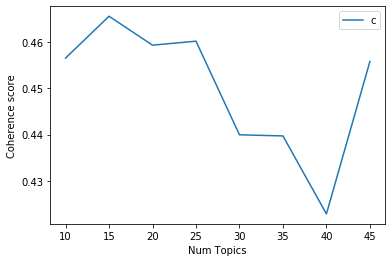

In [337]:
# Show graph
limit=50; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [338]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.4565
Num Topics = 15  has Coherence Value of 0.4655
Num Topics = 20  has Coherence Value of 0.4593
Num Topics = 25  has Coherence Value of 0.4601
Num Topics = 30  has Coherence Value of 0.44
Num Topics = 35  has Coherence Value of 0.4397
Num Topics = 40  has Coherence Value of 0.4229
Num Topics = 45  has Coherence Value of 0.4558


In [339]:
model_list2, coherence_values2 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=50, limit=70, step=5)

num_topics: 50
num_topics: 55
num_topics: 60
num_topics: 65


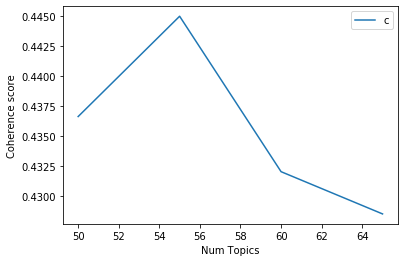

In [340]:
# Show graph
limit=70; start=50; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [341]:
# Print the coherence scores
for m, cv in zip(x, coherence_values2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 50  has Coherence Value of 0.4366
Num Topics = 55  has Coherence Value of 0.445
Num Topics = 60  has Coherence Value of 0.4321
Num Topics = 65  has Coherence Value of 0.4286
